In [1]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

# Import necessary libraries

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create a balanced dataset with distinct patterns

In [5]:
def create_balanced_dataset(sample_count=8000, img_dim=(28, 28), class_count=10):
    data = np.zeros((sample_count, *img_dim, 1))  # Initialize the dataset
    targets = np.zeros(sample_count)  # Initialize target labels

    for idx in range(sample_count):
        class_label = np.random.randint(0, class_count)
        targets[idx] = class_label

        # Generate patterns based on the class label
        if class_label == 0:
            # Draw a circle
            rr, cc = np.ogrid[:28, :28]
            mask = (rr - 14)**2 + (cc - 14)**2 < 10**2
            data[idx][mask] = 1
        elif class_label == 1:
            # Draw a square
            data[idx][10:18, 10:18, 0] = 1
        elif class_label == 2:
            # Draw a diagonal line
            np.fill_diagonal(data[idx, :, :, 0], 1)
        elif class_label == 3:
            # Draw an inverted diagonal line
            np.fill_diagonal(data[idx, ::-1, :, 0], 1)
        elif class_label == 4:
            # Draw a horizontal line
            data[idx][14, :, 0] = 1
        elif class_label == 5:
            # Draw a vertical line
            data[idx][:, 14, 0] = 1
        elif class_label == 6:
            # Draw two intersecting lines
            data[idx][10, :, 0] = 1
            data[idx][:, 10, 0] = 1
        elif class_label == 7:
            # Draw a cross
            data[idx][10:18, 14, 0] = 1
            data[idx][14, 10:18, 0] = 1
        elif class_label == 8:
            # Draw a plus sign
            data[idx][12, 10:18, 0] = 1
            data[idx][10:18, 12, 0] = 1
        elif class_label == 9:
            # Draw random noise
            data[idx] = np.random.rand(28, 28, 1)

        # Add random noise to the image
        noise = np.random.rand(28, 28, 1) * 0.2
        data[idx] += noise
        
        # Normalize the pixel values to [0, 1]
        data[idx] = np.clip(data[idx], 0, 1)

    targets = to_categorical(targets, class_count)  # One-hot encode the labels
    return data, targets


# Generate balanced datasets for training, validation, and testing

In [6]:
train_data, train_labels = create_balanced_dataset(8000)
val_data, val_labels = create_balanced_dataset(1000)
test_data, test_labels = create_balanced_dataset(1000)

print("Training data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)
print("Test data shape:", test_data.shape)

# Data augmentation setup
data_augmentation = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

Training data shape: (8000, 28, 28, 1)
Validation data shape: (1000, 28, 28, 1)
Test data shape: (1000, 28, 28, 1)


# Visualize the Data

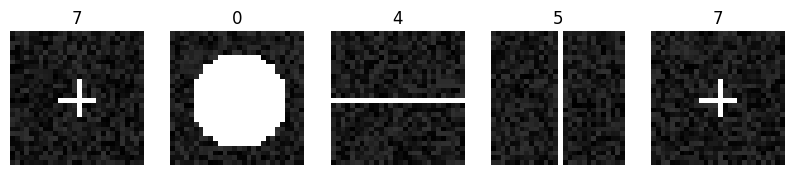

In [7]:
def visualize_data(images, labels, display_count=5):
    plt.figure(figsize=(10, 5))
    for i in range(display_count):
        plt.subplot(1, display_count, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(np.argmax(labels[i]))
        plt.axis('off')
    plt.show()

visualize_data(train_data, train_labels)


# Construct a CNN model

In [8]:
def build_cnn_model(input_shape=(28, 28, 1), num_classes=10):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

cnn_network = build_cnn_model()
cnn_network.compile(optimizer=Adam(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=['accuracy'])
cnn_network.summary()


e:\MTech Courses\CS786 Cognitive\Assignments\Assignment 3\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,370 (435.04 KB)

 Trainable params: 110,922 (433.29 KB)

 Non-trainable params: 448 (1.75 KB)

# Train the CNN with data augmentation

In [10]:
def train_cnn_with_augmentation(cnn_model, training_data, training_labels, validation_data, validation_labels, epochs=20, batch_size=32):
    training_history = cnn_model.fit(data_augmentation.flow(training_data, training_labels, batch_size=batch_size),
                                      validation_data=(validation_data, validation_labels),
                                      epochs=epochs)
    return training_history

# Train the CNN model
num_epochs = 15
batch_size = 32
training_history = train_cnn_with_augmentation(cnn_network, train_data, train_labels, val_data, val_labels, epochs=num_epochs, batch_size=batch_size)


Epoch 1/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.6275 - loss: 1.0383 - val_accuracy: 0.1990 - val_loss: 2.1065
Epoch 2/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.8509 - loss: 0.2997 - val_accuracy: 0.9050 - val_loss: 0.1499
Epoch 3/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.8819 - loss: 0.2117 - val_accuracy: 0.7420 - val_loss: 1.1392
Epoch 4/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.8857 - loss: 0.1947 - val_accuracy: 0.9050 - val_loss: 0.1245
Epoch 5/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.8887 - loss: 0.1862 - val_accuracy: 0.9090 - val_loss: 0.1369
Epoch 6/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.8885 - loss: 0.1746 - val_accuracy: 0.9980 - val_loss: 0.1546
Epoch 7/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.8910 - loss: 0.1841 - val_accuracy: 0.8900 - val_loss: 0.1798
Epoch 8/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.8862 - loss: 0.1879 - val_a

# Assess the Model's Performance

In [11]:
def assess_model_performance(model, test_data, test_labels):
    loss, accuracy = model.evaluate(test_data, test_labels)
    print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')
    return loss, accuracy

# Evaluate the model on test data
assess_model_performance(cnn_network, test_data, test_labels)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9008 - loss: 0.1511
Test Loss: 0.1455, Test Accuracy: 0.9020


(0.14545559883117676, 0.9020000100135803)